In [2]:
#NYT API docs: https://developer.nytimes.com/apis
#sklearn docs: https://scikit-learn.org/stable/
import requests
import json
import pandas as pd
import time 
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

#API code resources: https://medium.com/@chris.m.pease/starting-to-use-the-nytimes-api-and-diving-into-data-with-pandas-7e2df3787892
# and https://towardsdatascience.com/collecting-data-from-the-new-york-times-over-any-period-of-time-3e365504004

#sklearn code resources: https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a

In [ ]:
API_KEY = "INSERT YOUR API KEY HERE AS STRING"

In [17]:
#all articles from one month (Jan 2019)
month_url = 'https://api.nytimes.com/svc/archive/v1/2019/1.json?api-key=' + API_KEY
r = requests.get(month_url)

In [32]:
#all articles containing "climate change" from 2020
search_url = 'https://api.nytimes.com/svc/search/v2/articlesearch.json?q=climate+change&begin_date=20200101&end_date=20201231&api-key=' + API_KEY
climate = requests.get(search_url)

In [ ]:
#all comments from one article
#Note: comments not available for all articles
comments_url = "https://api.nytimes.com/svc/community/v3/user-content/url.json?api-key=" + API_KEY + "&offset=0&url=https%3A%2F%2Fwww.nytimes.com%2F2019%2F06%2F21%2Fscience%2Fgiant-squid-cephalopod-video.html"
c = requests.get(comments_url)

In [ ]:
#one article
r.json()['response']['docs'][2]
#number of articles returned 
len(r.json()['response']['docs'])

In [ ]:
#article title
r.json()['response']['docs'][1]['headline']['main']

In [3]:
#function to insert page number, date range in url; date format YYYYMMDD
#also input search words & your api key
def make_search_url(pg_num, start_date, end_date, api_key):
    url = "https://api.nytimes.com/svc/search/v2/articlesearch.json?q=climate+change&begin_date=" + str(start_date) + "&end_date=" + str(end_date) + "&page=" + str(pg_num) + "&api-key=" + str(api_key)
    return url

def make_comments_url(article_url, api_key):
    url = "https://api.nytimes.com/svc/community/v3/user-content/url.json?api-key=" + str(api_key) + "&offset=0&url=" + article_url
    return url

In [ ]:
#Note: this will take a while to run 
#input api key
climate_docs = []
for i in range(0,10):
    url = make_search_url(i,20200101,20200530, API_KEY)
    req = requests.get(url)
    all_docs = req.json()['response']['docs']
    climate_docs = climate_docs + all_docs
    print(i)
    print(url)
    print(len(climate_docs))
    if (len(all_docs) < 10):
        break 
    time.sleep(7) #pause 7 seconds

In [25]:
#initialize empty lists that will be columns of data frame
title = []
date = []
news_desk = []
abstract = []
url = []

In [26]:
#iterate through docs and extract data
for doc in climate_docs:
    title.append(doc['headline']['main'])
    date.append(doc['pub_date'])
    news_desk.append(doc['news_desk'])
    abstract.append(doc['abstract'])
    url.append(doc['web_url'])

In [12]:
#make dictionary & convert to pandas dataframe & save as csv
df = {'title': title,
     'date': date,
     'news_desk': news_desk,
     'abstract': abstract,
     'url' : url}
df = pd.DataFrame(df) 
df.to_csv('NYT_climate.csv')

In [3]:
#import csv as pandas dataframe
articles = pd.read_csv('NYT_climate.csv')
articles['date'] = pd.to_datetime(articles['date'])

In [5]:
#convert abstracts to tfidf data frame
tfidf = TfidfVectorizer(stop_words = 'english') #remove stopwords
mod = tfidf.fit_transform(articles['abstract']) #calculate tfidf scores
toks = tfidf.get_feature_names() #doc tokens

In [6]:
tok_tfidf = pd.DataFrame(data = mod.toarray(), index = articles['title'], columns = toks)

In [ ]:
tok_tfidf.iloc[0,5]

In [42]:
max_tfidf = tok_tfidf.max(axis=1) #max tfidf value
max_toks = tok_tfidf.idxmax(axis=1) #words associated with max values
val_df = pd.DataFrame(max_tfidf)
tok_df = pd.DataFrame(max_toks)

In [45]:
tok_df['tfidf'] = val_df
tok_df.columns = {'tokens', 'tfidf'}

In [ ]:
tok_df

In [ ]:
tok_tfidf

In [6]:
#try out sentiment analysis using TextBlob
#it uses a pre-trained Naive Bayes Classifier
sentiment = []
subjectivity = []
def get_sentiment(doc):
    blob = TextBlob(doc)
    sentiment.append(blob.sentiment.polarity)
    subjectivity.append(blob.sentiment.subjectivity)
articles.abstract.apply(get_sentiment)
articles['sentiment'] = sentiment
articles['subjectivity'] = subjectivity
    

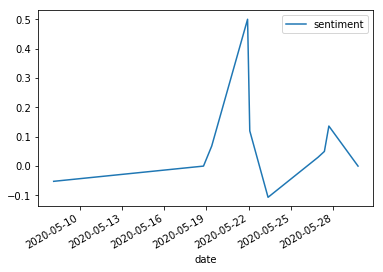

In [18]:
%matplotlib inline
articles.plot(x="date",y="sentiment")